In [11]:
import pandas as pd
import numpy as np
# import category_encoders as ce
# import copy
# import polars as pl

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import matplotlib
import seaborn as sns
# import plotly.express as px
# %matplotlib inline
# matplotlib.rcParams['font.family'] = 'Malgun Gothic' # 한글 패치
# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.decomposition import PCA

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
# from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor, XGBRFRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, VotingRegressor
from sklearn.ensemble import StackingClassifier, StackingRegressor
# from sklearn.base import ClassifierMixin

# CatBoost
# from catboost import CatBoostRegressor

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss,mean_squared_error

# Utility
import os
import time
import datetime # ⚠️2019년 12월30일과 31일의 week of year가 1인 오류가 있음
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean
import holidays

# from bayes_opt import BayesianOptimization
# from num2words import num2words
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

pd.set_option('display.max_row',None)
pd.set_option('display.max_column',None)

try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: not using Google CoLab
Using device: cuda


뉴스 데이터랑 주가 데이터 합치기

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class PrepareData():
    def __init__(self,stock_fp,news_fp):
        self.stock_filepath = stock_fp
        self.news_filepath = news_fp
        self.topic_classes = ['CEO', 'CFO', 'Layoffs', 'Political', 'PressRelease', 'Undefined',
       'cramer', 'earnings', 'gold', 'manda', 'paylimitwall', 'paywall',
       'product', 'recession', 'tanalysis'] # undefined의 class가 5

    def load_data(self):
        stock = pd.read_csv(self.stock_filepath,index_col=0)
        news = pd.read_csv(self.news_filepath,index_col=0)
        ### parse date manually
        stock['Date'] = pd.to_datetime(stock['Date'])
        news['date'] = pd.to_datetime(news['date'])
        return stock, news

    def merging(self, stock, news):
        ### fill na value of PINS column
#         stock['PINS'] = stock['PINS'].fillna(stock['PINS'].iloc[75])

        ### drop 'news_id' column
#         news = news.drop(columns=['news_id'])

        ### add date range from 18.01.02 to 18.12.31
        temp_range = pd.DataFrame(dict(zip(stock.columns,[pd.date_range(start='2018-01-02',end='2018-12-31'),
                                0,0,0,0, # 4
                                0,0,0,0,
                                0,0,0,0,
                                0,0,0,0, # 16
                                0,0,0,0,
                                0,0,0,0,
                                0,0,0,0, # 28
                                0,0,0,0,
                                0,0,0,0, # 36
                                0 # 37
                            ])))
        stock_inc = pd.concat([temp_range,stock],axis=0)

        ### merge stock_inc and news
        # left = stock_inc
        # on = date
        # how = left
        # rename 'date' to 'Date' of news df
        news = news.rename(columns={'date':'Date'})
        merged = pd.merge(left=stock_inc,right=news,on='Date',how='left')

        ### Cut before 2018-02-13
        merged = merged[42:].reset_index(drop=True)

        # fill na with latest non-null values
        columns_to_fill = ['source_name', 'topics', 'rank_score',
                        'sentiment_Negative','sentiment_Neutral',
                        'sentiment_Positive', 'type_Article', 'type_Video']
        merged_fillna = merged.copy()
        for column in columns_to_fill:
            merged_fillna[column].fillna(method='ffill',inplace=True)

        ### add moving average to sentiments
        ma_nums = [5,60,120]
        def mode_window(window):
            return window.mode().iloc[0] if not len(window.mode())==0 else None
        for num in ma_nums:
            merged_fillna[f'{num}MA_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
            window=num).mean()
            merged_fillna[f'{num}MA_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
            window=num).mean()
            merged_fillna[f'{num}MA_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
            window=num).mean()
        ### add moving mode to sentiments
        for num in ma_nums:
            merged_fillna[f'{num}MM_sent_Neg']=merged_fillna['sentiment_Negative'].rolling(
            window=num).apply(mode_window)
            merged_fillna[f'{num}MM_sent_Neu']=merged_fillna['sentiment_Neutral'].rolling(
            window=num).apply(mode_window)
            merged_fillna[f'{num}MM_sent_Pos']=merged_fillna['sentiment_Positive'].rolling(
            window=num).apply(mode_window)
        ### adding moving mode to topics
        for num in ma_nums:
            merged_fillna[f'{num}MM_topics']=merged_fillna['topics'].rolling(
            window=num).apply(mode_window)

        ### drop before 2019-01-02
        total_df = merged_fillna.iloc[322:]
        total_df = total_df.reset_index(drop=True)

        ### drop unnecessaray columns
        drop_cols = ['source_name','topics','rank_score',
                    'sentiment_Negative','sentiment_Neutral',
                    'sentiment_Positive','type_Article','type_Video']
        total_df = total_df.drop(columns=drop_cols)

        return total_df

In [13]:
# stock_filepath = 'netflix_60.csv' # 각자 파일 경로 설정
# news_filepath = 'news_processed_filtered_2.csv'
stock_filepath = '../../data/stock_price/netflix_60.csv' # 각자 파일 경로 설정
news_filepath = '../../data/scraping/news_processed_filtered_2.csv'
loader = PrepareData(stock_filepath, news_filepath)
stock_df, news_df=loader.load_data() # >> 감성분석 미포함으로 모델 돌릴 땐 stock_df 바로 사용하면 됨
total_df = loader.merging(stock=stock_df, news=news_df) # 주식데이터셋에 감성분석,토픽 포함시킨 전체 데이터셋

# LSTM with 120 window size

In [14]:
total_df.isnull().sum()
total_df.head(5)

,Date,Open,Close,High,Low,Volume,1d_ROC,5d_ROC,5MA,120MA,bol_high,bol_low,ADI,OBV,CMF,FI,EOM,VPT,NVI,ATR,UI,MACD,ADX,-VI,+VI,TRIX,MI,CCI,DPO,KST,STC,RSI,SRSI,UO,MFI,SPOT,PINS,FB,5MA_sent_Neg,5MA_sent_Neu,5MA_sent_Pos,60MA_sent_Neg,60MA_sent_Neu,60MA_sent_Pos,120MA_sent_Neg,120MA_sent_Neu,120MA_sent_Pos,5MM_sent_Neg,5MM_sent_Neu,5MM_sent_Pos,60MM_sent_Neg,60MM_sent_Neu,60MM_sent_Pos,120MM_sent_Neg,120MM_sent_Neu,120MM_sent_Pos,5MM_topics,60MM_topics,120MM_topics
0,2019-01-02,259.28,267.66,269.75,256.58,11642148,0.000000,14.443304,260.128,325.000667,286.872017,242.471983,1.326076e+08,114631377,-0.061244,1.080230e+07,-213.237712,5.182140e+06,1127.288880,15.042858,8.947993,-7.398435,25.068628,1.070193,0.878804,-0.468704,24.924196,-72.480377,2.1680,-88.281564,44.762606,45.523889,0.384404,48.377492,44.377291,135.68,NaN,113.74,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7.0,7.0,7.0
1,2019-01-03,270.20,271.20,275.79,264.43,14954204,1.322573,6.910553,263.634,323.962333,286.339561,242.591439,1.354773e+08,129585581,-0.064746,1.682167e+07,527.578733,5.379921e+06,1127.288880,14.981477,8.846980,-6.060607,23.675017,1.054425,0.890686,-0.441866,24.927295,-56.022123,-1.6655,-86.593692,64.779342,45.949547,0.424055,49.951722,46.086376,131.74,NaN,109.02,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7.0,7.0,7.0
2,2019-01-04,281.88,297.57,297.80,278.54,19309374,9.723451,16.433854,272.034,323.104750,291.444515,239.710485,1.543255e+08,148894955,-0.046626,8.715975e+07,1801.382064,7.257458e+06,1127.288880,15.175119,8.748754,-2.839794,23.280846,1.036458,0.890141,-0.390592,24.917587,1.767185,5.3625,-75.831614,79.644575,48.970092,0.705424,53.480333,46.642910,137.95,NaN,118.51,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7.0,7.0,7.0
3,2019-01-07,302.10,315.34,316.80,301.65,18598132,5.971704,23.141206,283.886,322.570250,300.275444,234.125556,1.693391e+08,167493087,-0.009259,1.219210e+08,1715.135961,8.368084e+06,1194.607237,15.242701,8.477965,1.133546,23.924840,1.019173,0.928652,-0.311443,24.915600,59.409267,-0.4305,-56.832386,89.822288,50.852293,0.880754,56.283542,48.992941,138.05,NaN,119.36,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7.0,7.0,7.0
4,2019-01-08,319.98,320.27,320.59,308.01,15324452,1.563392,19.655533,294.408,322.113083,310.280492,229.633508,1.838839e+08,182817539,0.015975,1.152965e+08,416.611961,8.607665e+06,1213.283630,15.198322,8.091113,4.626921,24.695894,0.995371,0.943656,-0.212544,24.968010,74.434105,-9.3770,-28.087969,94.911144,51.358475,0.927906,59.329800,51.038876,142.53,NaN,117.48,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7.0,7.0,7.0


In [15]:
total_df['PINS'].fillna(24.99, inplace = True)

split_xy 함수를 통해 x와 y 분리

In [16]:
def split_xy(dataset, time_steps, y_column):
    x, y = list(), list()
    for i in range(len(dataset)):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column

        if y_end_number > len(dataset):
            break
        tmp_x = dataset.iloc[i:x_end_number, 1:]  # Adjusted for Pandas
        tmp_y = dataset.iloc[x_end_number:y_end_number, 2]  # Adjusted for Pandas
        x.append(tmp_x.values)  # Convert to numpy array
        y.append(tmp_y.values)  # Convert to numpy array

    return np.array(x), np.array(y)


x, y = split_xy(total_df, 60, 10)
print(x[0,:],"\n", y[0])
print(x.shape)
print(y.shape)

[[259.28 267.66 269.75 ...   7.     7.     7.  ]
 [270.2  271.2  275.79 ...   7.     7.     7.  ]
 [281.88 297.57 297.8  ...   7.     7.     7.  ]
 ...
 [367.87 359.97 368.38 ...   7.     7.     7.  ]
 [361.   353.37 362.47 ...   7.     7.     7.  ]
 [354.48 354.61 355.94 ...   7.     7.     7.  ]] 
 [356.56 366.96 367.72 369.75 367.88 365.49 361.41 364.71 363.92 367.65]
(1188, 60, 58)
(1188, 10)


In [17]:
x.shape

(1188, 60, 58)

테스트에 쓸 X_test 따로 정의하기

In [18]:
total_df.columns

Index(['Date', 'Open', 'Close', 'High', 'Low', 'Volume', '1d_ROC', '5d_ROC',
       '5MA', '120MA', 'bol_high', 'bol_low', 'ADI', 'OBV', 'CMF', 'FI', 'EOM',
       'VPT', 'NVI', 'ATR', 'UI', 'MACD', 'ADX', '-VI', '+VI', 'TRIX', 'MI',
       'CCI', 'DPO', 'KST', 'STC', 'RSI', 'SRSI', 'UO', 'MFI', 'SPOT', 'PINS',
       'FB', '5MA_sent_Neg', '5MA_sent_Neu', '5MA_sent_Pos', '60MA_sent_Neg',
       '60MA_sent_Neu', '60MA_sent_Pos', '120MA_sent_Neg', '120MA_sent_Neu',
       '120MA_sent_Pos', '5MM_sent_Neg', '5MM_sent_Neu', '5MM_sent_Pos',
       '60MM_sent_Neg', '60MM_sent_Neu', '60MM_sent_Pos', '120MM_sent_Neg',
       '120MM_sent_Neu', '120MM_sent_Pos', '5MM_topics', '60MM_topics',
       '120MM_topics'],
      dtype='object')

In [8]:
def return_test_X(dataset, time_steps):
    x = list()
    # Loop over the dataset
    for i in range(len(dataset) - time_steps + 1):
        x_end_number = i + time_steps
        # Ensure we don't go past the end of the dataset
        if x_end_number > len(dataset):
            break
        tmp_x = dataset.iloc[i:x_end_number, 1:]  # Adjusted for Pandas
        x.append(tmp_x.values)  # Convert to numpy array

    # Make sure to return an array of the correct shape
    return np.array(x, dtype=object)

# Assuming nflx_data is your full dataset and you want the last 60 days as your test set
x_test = return_test_X(total_df.tail(60), 60)
print(x_test[0, :, :])
print(x_test.shape)


[[378.01 372.59 378.6 ... 7.0 7.0 7.0]
 [368.43 381.51 382.52 ... 7.0 7.0 7.0]
 [378.05 385.95 387.17 ... 7.0 7.0 7.0]
 ...
 [491.24 491.79 494.02 ... 7.0 7.0 7.0]
 [492.0 490.51 492.89 ... 7.0 7.0 7.0]
 [490.37 486.88 492.23 ... 7.0 7.0 7.0]]
(1, 60, 58)


데이터 표준 정규화

In [9]:
from sklearn.preprocessing import StandardScaler

x_train = x[:1257]
y_train = y[:1257]

# 데이터셋 스케일링
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1] * x_train.shape[2]))
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)

# 테스트 데이터셋 생성
x_test = return_test_X(total_df.tail(60), 60)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] * x_test.shape[2]))
x_test_scaled = scaler.transform(x_test)


In [10]:
# reshape to (None,5,5)
x_train = np.reshape(x_train_scaled,
                    (x_train_scaled.shape[0],60,58))
x_test = np.reshape(x_test_scaled,
                    (x_test_scaled.shape[0],60,58))
print(x_train.shape, x_test.shape, sep='\n')
# batch_size, time_step, features

(1188, 60, 58)
(1, 60, 58)


LSTM 모델 설계하기

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
from torch.optim.lr_scheduler import ReduceLROnPlateau

import copy
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

class LSTMModel(nn.Module):
    def __init__(self,input_dim):
        super(LSTMModel,self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_size=64, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.seq = nn.Sequential(nn.Linear(64,32),
                                nn.ReLU(),
                                nn.Linear(32,32),
                                nn.ReLU(),
                                nn.Linear(32,32),
                                nn.ReLU(),
                                nn.Linear(32,32),
                                nn.ReLU(),
                                nn.Linear(32,10)
                                )

    def forward(self,x):
        x,_ = self.lstm(x)
#         print('output of lstm :',x.size()) # torch.Size([1, 120, 64])
        x = self.dropout(x[:,-1,:])
#         print('from lstm to linear :',x.size()) # torch.Size([1, 64])
        x = self.seq(x)
        return x

class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()
        self.mse = nn.MSELoss()

    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [12]:
model = LSTMModel(x_train.shape[2])

In [13]:
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=20,verbose=True)

In [14]:
# to DataLoader
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_train,y_train,
                                           random_state=1,test_size=0.2)

# to tensor
x_tr_tensor = torch.tensor(x_tr.astype(np.float32),dtype=torch.float32)
x_val_tensor = torch.tensor(x_val.astype(np.float32),dtype=torch.float32)
y_tr_tensor = torch.tensor(y_tr.astype(np.float32),dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.astype(np.float32),dtype=torch.float32)

# to DataLoader
batch_size = 5
train_loader = DataLoader(TensorDataset(x_tr_tensor,y_tr_tensor),
                         batch_size=batch_size,shuffle=True)
val_loader = DataLoader(TensorDataset(x_val_tensor,y_val_tensor),
                       batch_size=batch_size,shuffle=False)

In [15]:
EPOCHS = 1000
epoch_counter = 0
patience = 30
best_loss = float('inf')
done = False
es = EarlyStopping(patience=patience)
tr_losses_fp, val_losses_fp = [],[]

while not done and epoch_counter<EPOCHS:
    epoch_counter+=1

    # train
    model.train()
    train_losses = []
    for x_batch,y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output,y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    tr_losses_fp.append(train_loss)

    # validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            output = model(x_batch)
            loss = criterion(output, y_batch)
            val_losses.append(loss.item())
    val_loss = np.mean(val_losses)
    val_losses_fp.append(val_loss)
    scheduler.step(val_loss)

    if es(model, val_loss):
        done = True

    print(f"Epoch {epoch_counter}/{EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/1000, Train Loss: 277.4044, Validation Loss: 251.7496
Epoch 2/1000, Train Loss: 89.1519, Validation Loss: 25.7540
Epoch 3/1000, Train Loss: 35.5476, Validation Loss: 26.5795
Epoch 4/1000, Train Loss: 35.4403, Validation Loss: 24.2804
Epoch 5/1000, Train Loss: 36.7870, Validation Loss: 24.9550
Epoch 6/1000, Train Loss: 34.3846, Validation Loss: 23.6004
Epoch 7/1000, Train Loss: 34.7202, Validation Loss: 23.3775
Epoch 8/1000, Train Loss: 32.4272, Validation Loss: 24.2505
Epoch 9/1000, Train Loss: 31.8878, Validation Loss: 22.8184
Epoch 10/1000, Train Loss: 33.8736, Validation Loss: 28.0672
Epoch 11/1000, Train Loss: 32.4080, Validation Loss: 23.7760
Epoch 12/1000, Train Loss: 31.9234, Validation Loss: 20.2438
Epoch 13/1000, Train Loss: 31.8741, Validation Loss: 21.1512
Epoch 14/1000, Train Loss: 31.1525, Validation Loss: 22.5067
Epoch 15/1000, Train Loss: 31.3461, Validation Loss: 20.6656
Epoch 16/1000, Train Loss: 30.6760, Validation Loss: 19.9381
Epoch 17/1000, Train Loss: 30.5

훈련 셋과 검증 셋에 대한 loss 시각화하기

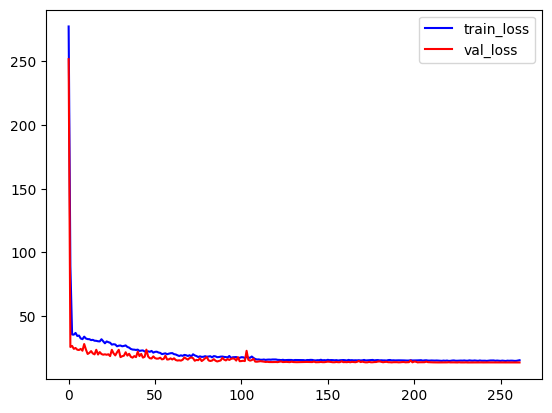

In [28]:
import matplotlib.pyplot as plt
plt.plot(range(len(tr_losses_fp)),tr_losses_fp,color='blue',label='train_loss')
plt.plot(range(len(val_losses_fp)),val_losses_fp,color='red',label='val_loss')
plt.legend()
plt.show()

평가 및 예측

In [29]:
# evaluation
model.eval()
with torch.no_grad():
    x_test_tensor = torch.tensor(x_test.astype(np.float32),dtype=torch.float32)
    pred = model(x_test_tensor)

In [30]:
pred_np = pred.detach().numpy()

In [31]:
print(pred_np)

[[476.18857 476.2378  476.67148 477.10492 477.48236 477.87592 477.85593
  478.16876 478.5765  478.27158]]


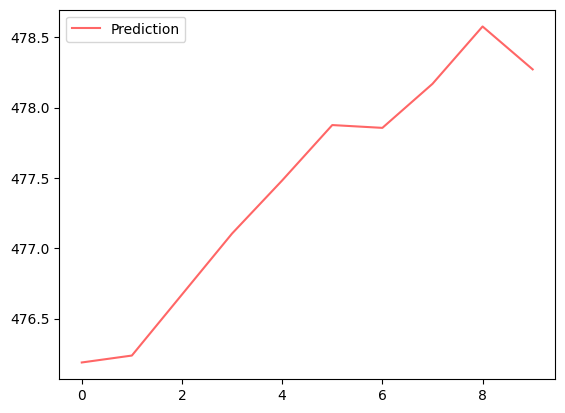

In [32]:
# 예측된 값의 길이를 계산합니다.
pred_length = len(np.reshape(pred_np, (-1)))

# 예측된 값들의 인덱스를 생성합니다. 여기서는 단순히 0부터 시작하는 정수 시퀀스를 사용합니다.
pred_indices = list(range(pred_length))

# 예측값을 그래프로 표시합니다.
plt.plot(pred_indices, np.reshape(pred_np, (-1)), color='red', alpha=0.6, label='Prediction')

# 그래프에 범례를 추가합니다.
plt.legend()

# 그래프를 표시합니다.
plt.show()


실제 종가와 예측가 비교하기

In [35]:
jan = pd.read_csv('2024_JAN.csv')
jan = jan.head(10)
jan

,Date,Close Price
0,2024-01-02,468.50
1,2024-01-03,470.26
2,2024-01-04,474.67
3,2024-01-05,474.06
4,2024-01-08,485.03
5,2024-01-09,482.09
6,2024-01-10,478.33
7,2024-01-11,492.23
8,2024-01-12,492.16
9,2024-01-16,481.24


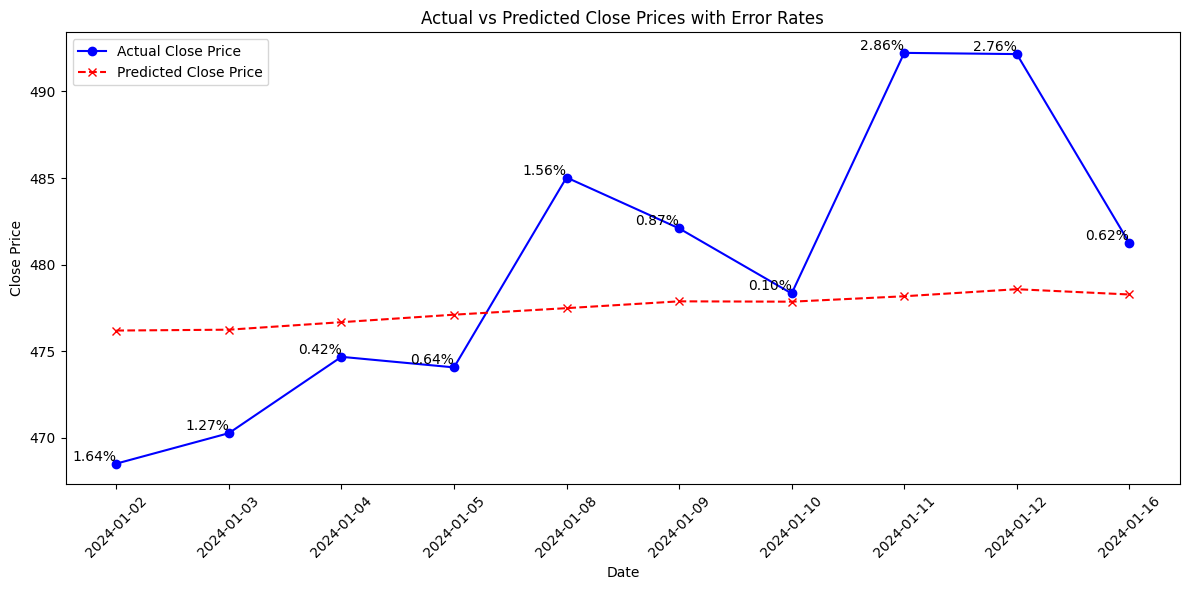

{'2024-01-02': 1.6411031195804429,
 '2024-01-03': 1.271167645291968,
 '2024-01-04': 0.4216567871330312,
 '2024-01-05': 0.6423067615056633,
 '2024-01-08': 1.5561180051040602,
 '2024-01-09': 0.8741281654164627,
 '2024-01-10': 0.09911013031340479,
 '2024-01-11': 2.8566397401557744,
 '2024-01-12': 2.7599748926448,
 '2024-01-16': 0.6168282088491468}

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# 실제 종가 데이터
actual_prices = np.array([468.50, 470.26, 474.67, 474.06, 485.03,
                          482.09, 478.33, 492.23, 492.16, 481.24])

# 예측된 종가 데이터 (이전의 예측 결과를 사용한다고 가정)
# pred_np 변수에 예측값이 저장되어 있다고 가정합니다. 실제 예측값을 여기에 할당해야 합니다.
# 예시: pred_np = model.predict(x_test_scaled)
# 여기서는 예시 데이터를 사용하겠습니다.
# 예시 예측값

pred_np = np.array(pred_np.reshape(10,))

# 날짜 데이터
dates = ["2024-01-02", "2024-01-03", "2024-01-04", "2024-01-05",
         "2024-01-08", "2024-01-09", "2024-01-10", "2024-01-11",
         "2024-01-12", "2024-01-16"]

# 오차율 계산
error_rate = np.abs((actual_prices - pred_np) / actual_prices) * 100

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_prices, marker='o', color='blue', label='Actual Close Price')
plt.plot(dates, pred_np, marker='x', color='red', linestyle='--', label='Predicted Close Price')

# 오차율을 각 포인트에 텍스트로 표시
for i, (date, actual, prediction, error) in enumerate(zip(dates, actual_prices, pred_np, error_rate)):
    plt.text(date, actual, f'{error:.2f}%', color='black', ha='right', va='bottom')

plt.xticks(rotation=45)  # 날짜 레이블 회전
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices with Error Rates')
plt.legend()
plt.tight_layout()  # 레이아웃 조정
plt.show()

# 오차율을 출력
error_rate_dict = dict(zip(dates, error_rate))
error_rate_dict


In [37]:
# 평균 오차율 계산
average_error_rate = np.mean(error_rate)

print(f"Average Error Rate: {average_error_rate:.2f}%")


Average Error Rate: 1.27%
